In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [49]:
import pandas
import gensim

import matplotlib.pyplot as plt
import matplotlib

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import numpy as np

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

matplotlib.style.use('ggplot')

## 1. Read data

In [3]:
data_file = "../data/a0201.log.txt"

data = pandas.read_csv(data_file, sep = ',')

In [4]:
data.head()

,sequence,length,meas,netmhc,netmhcpan,smmpmbec_cpp
0,AAAFVNQHL,9,0.212593,0.140876,0.104910,0.187482
1,AAAQGQAPL,9,0.084693,0.200676,0.125553,0.259838
2,AADSFATSY,9,0.084693,0.051707,0.064689,0.000000
3,AALGLWLSV,9,0.260051,0.451795,0.516490,0.444772
4,AALQGGGPP,9,0.000000,0.044471,0.017657,0.000000


## 2. To one hot

In [5]:
indexes = data['sequence'][data['length'] == 9].index
#indexes = data.index
selected_X = data['sequence'][indexes]
selected_y = pandas.DataFrame(data['meas'][indexes])
selected_y['netmhc'] = pandas.DataFrame(data['netmhc'][indexes])
selected_y['netmhcpan'] = pandas.DataFrame(data['netmhcpan'][indexes])
selected_y['smmpmbec_cpp'] = pandas.DataFrame(data['smmpmbec_cpp'][indexes])

letters_X = selected_X.apply(list)

selected_X = pandas.DataFrame(list(letters_X))
selected_X = pandas.get_dummies(selected_X)

#XX = selected_X[range(0, 20)].as_matrix() + selected_X[range(20, 40)].as_matrix() + selected_X[range(40, 60)].as_matrix() + selected_X[range(60, 80)].as_matrix() + selected_X[range(80, 100)].as_matrix() + selected_X[range(100, 120)].as_matrix() + selected_X[range(120, 140)].as_matrix() + selected_X[range(140, 160)].as_matrix() + selected_X[range(160, 180)].as_matrix()
selected_X[selected_X == 1] = 0.9
selected_X[selected_X == 0] = 0.05
#selected_X = pandas.concat([selected_X, pandas.DataFrame(XX)], axis=1)


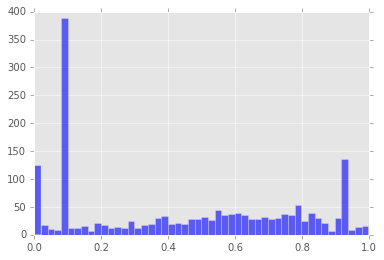

In [18]:
hh = plt.hist(selected_y['meas'], 50, color = 'blue', alpha = 0.6)

In [24]:
t = selected_y['meas'] < 0.2
n = selected_y['netmhc'] < 0.2

sum(t == n) / float(selected_y.shape[0])

0.89088863892013503

## 3. ml stuff

In [37]:
#normalize output
# m = selected_y.mean()
# d = selected_y.max() - selected_y.min()
# selected_y = (selected_y - m) / d

# train/test split
random_number = 53
X_train, X_test, y_train, y_test = train_test_split(selected_X, selected_y,
                                                    test_size = 0.33, random_state = random_number)

test_index = y_test.index
rss_netmhc = sum((y_test['netmhc'] - y_test['meas'])**2)
rss_netmhcpan = sum((y_test['netmhcpan'] - y_test['meas'])**2)
rss_smmpmbec_cpp = sum((y_test['smmpmbec_cpp'] - y_test['meas'])**2)

t = y_test['meas'] == 0
n = y_test['netmhc'] < 0.2




0.071550255536626917

In [138]:
def ridge_regression(X, y, alpha):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(X, y)
    y_pred = ridgereg.predict(X)
    
    #Return the result in pre-defined format
    rss = sum((y_pred - y)**2)
    return rss, ridgereg.intercept_, ridgereg

def log_regression(X, y, niter):
    logreg = LogisticRegression(C=1, penalty='l1', tol=0.2)
    logreg.fit(X, y)
    y_pred = logreg.predict(X)
    
    rss = sum((y_pred - y)**2)
    return rss, logreg.intercept_, logreg

In [151]:
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 0.01, 0.05, 0.1, 0.2]

rss = [0] * 10
intercept = [0] * 10
predictors = [0] * 10

for i in range(10):
    rss[i], intercept[i], predictors[i] = ridge_regression(X_train, y_train['meas'], alpha_ridge[i])

In [152]:
# predict test data

test_rss = [0] * 10
for i in range(10):
    m_pred = predictors[i]
    test_pred = m_pred.predict(X_test)
    test_rss[i] = sum((test_pred - y_test['meas'])**2)
    
    print '-' * 10
    print "alpha = ", alpha_ridge[i]
    print "train rss = ", rss[i]
    print "test rss = ", test_rss[i]
    
m_pred = predictors[5]
test_pred = m_pred.predict(X_test)
t_rss = sum((test_pred - y_test['meas'])**2)

----------
alpha =  1e-15
train rss =  36.0046513133
test rss =  23.8430098283
----------
alpha =  1e-10
train rss =  36.0046513133
test rss =  23.8430098278
----------
alpha =  1e-08
train rss =  36.0046513133
test rss =  23.8430097811
----------
alpha =  0.0001
train rss =  36.0046517382
test rss =  23.8425386252
----------
alpha =  0.001
train rss =  36.0046937227
test rss =  23.8383262803
----------
alpha =  0.01
train rss =  36.0088124987
test rss =  23.7989626813
----------
alpha =  0.01
train rss =  36.0088124987
test rss =  23.7989626813
----------
alpha =  0.05
train rss =  36.1006114892
test rss =  23.678762735
----------
alpha =  0.1
train rss =  36.3541829205
test rss =  23.6317218122
----------
alpha =  0.2
train rss =  37.186602604
test rss =  23.7795491493


In [153]:
print "netmhc result", rss_netmhc
print "netmhcpan result", rss_netmhcpan
print "smmpmbec_cpp result", rss_smmpmbec_cpp
print "our result", t_rss

netmhc result 17.167122575
netmhcpan result 17.6484859848
smmpmbec_cpp result 19.922553449
our result 23.7989626813


In [157]:
sum((y_test['meas'] > 0.2) == (test_pred > 0.2))

487

## NN

In [11]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

y_train = y_train['meas'].as_matrix().flatten()
y_test = y_test['meas'].as_matrix().flatten()

In [12]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(1))

model.compile(loss='mse', optimizer='rmsprop')

In [13]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=500, verbose=2, validation_split=0.15)

Train on 1012 samples, validate on 179 samples
Epoch 1/500
0s - loss: 0.0941 - val_loss: 0.0626
Epoch 2/500
0s - loss: 0.0544 - val_loss: 0.0546
Epoch 3/500
0s - loss: 0.0452 - val_loss: 0.0519
Epoch 4/500
0s - loss: 0.0423 - val_loss: 0.0487
Epoch 5/500
0s - loss: 0.0364 - val_loss: 0.0507
Epoch 6/500
0s - loss: 0.0305 - val_loss: 0.0501
Epoch 7/500
0s - loss: 0.0270 - val_loss: 0.0473
Epoch 8/500
0s - loss: 0.0245 - val_loss: 0.0590
Epoch 9/500
0s - loss: 0.0219 - val_loss: 0.0449
Epoch 10/500
0s - loss: 0.0198 - val_loss: 0.0439
Epoch 11/500
0s - loss: 0.0188 - val_loss: 0.0453
Epoch 12/500
0s - loss: 0.0151 - val_loss: 0.0454
Epoch 13/500
0s - loss: 0.0142 - val_loss: 0.0459
Epoch 14/500
0s - loss: 0.0156 - val_loss: 0.0459
Epoch 15/500
0s - loss: 0.0128 - val_loss: 0.0503
Epoch 16/500
0s - loss: 0.0119 - val_loss: 0.0488
Epoch 17/500
0s - loss: 0.0127 - val_loss: 0.0471
Epoch 18/500
0s - loss: 0.0101 - val_loss: 0.0449
Epoch 19/500
0s - loss: 0.0102 - val_loss: 0.0441
Epoch 20/500

In [14]:
preds = model.predict(X_test, verbose=0).flatten()

sum((preds - y_test)**2)

22.282133828962763

In [15]:
preds2 = preds.clip(min = 0)
preds2 = preds2.clip(max = 1)
sum((preds2 - y_test)**2)

22.273057232793906

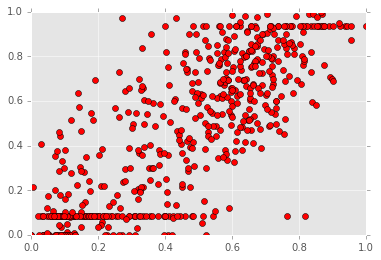

In [16]:
plt.plot(preds2, y_test, 'ro')

In [26]:
t = y_test < 0.2
n = preds2 < 0.2

sum(t == n) / float(y_test.shape[0])

0.83475298126064734